DATA PREPROCESSING

In [ ]:
import pandas as pd
from datetime import datetime

def convert_to_iso8601_safe(timestamp_str):
    try:
        # Parsing the given timestamp format
        dt = datetime.strptime(timestamp_str, '%a, %d %b %Y %H:%M:%S GMT')
        # Converting to ISO 8601 format with 'Z' indicating UTC timezone
        return dt.isoformat() + 'Z'
    except (TypeError, ValueError):
        # Return the original string if conversion fails
        return timestamp_str

def convert_csv_timestamps(file_path):
    # Load the CSV file
    data = pd.read_csv(file_path)

    # List of timestamp columns to convert
    timestamp_columns = ['connectionTime', 'disconnectTime', 'doneChargingTime']

    # Applying the conversion to each column
    for column in timestamp_columns:
        data[column] = data[column].apply(convert_to_iso8601_safe)

    # Save the updated dataframe back to CSV
    output_file_path = 'updated_' + file_path
    data.to_csv(output_file_path, index=False)


    return output_file_path

# Path to your CSV file
file_path = 'train.csv'

# Call the function with your file path
updated_file_path = convert_csv_timestamps(file_path)

print(f"Updated CSV file saved to: {updated_file_path}")

def add_end_time_column(file_path):
    # Load the CSV file
    data = pd.read_csv(file_path)

    # Convert 'disconnectTime' and 'doneChargingTime' to datetime format
    data['disconnectTime'] = pd.to_datetime(data['disconnectTime'], errors='coerce', format='%Y-%m-%dT%H:%M:%SZ')
    data['doneChargingTime'] = pd.to_datetime(data['doneChargingTime'], errors='coerce', format='%Y-%m-%dT%H:%M:%SZ')

    # Create a new column 'endTime' with the minimum of 'disconnectTime' and 'doneChargingTime'
    data['endTime'] = data[['disconnectTime', 'doneChargingTime']].min(axis=1)

    # Save the updated dataframe back to a new CSV
    output_file_path = 'train2.csv'
    data.to_csv(output_file_path, index=False)

    return output_file_path

# Path to your updated CSV file
updated_file_path = 'updated_train.csv'

# Call the function with your updated file path
final_file_path = add_end_time_column(updated_file_path)

print(f"Final CSV file with 'endTime' column saved to: {final_file_path}")


def calculate_time_difference(file_path):
    # Load the CSV file
    data = pd.read_csv(file_path)

    # Convert 'endTime' to datetime format (assuming 'endTime' is in 'YYYY-MM-DD HH:MM:SS' format)
    data['endTime'] = pd.to_datetime(data['endTime'], errors='coerce', format='%Y-%m-%d %H:%M:%S')

    # Convert 'connectionTime' to datetime format and remove timezone (making it timezone-naive)
    data['connectionTime'] = pd.to_datetime(data['connectionTime'], errors='coerce').dt.tz_localize(None)

    # Calculate the difference and store it in 'diffTime' column
    data['diffTime'] = data['endTime'] - data['connectionTime']

    # Convert 'diffTime' to total seconds for a numerical representation
    data['diffTime'] = data['diffTime'].dt.total_seconds()

    # Save the updated dataframe back to a new CSV
    output_file_path = 'train3.csv'
    data.to_csv(output_file_path, index=False)

    return output_file_path

# Path to your file
file_path = 'train2.csv'

# Call the function with your file path
final_file_path = calculate_time_difference(file_path)

print(f"Final CSV file with 'diffTime' column saved to: {final_file_path}")

df = pd.read_csv('train3.csv')

# Check if 'kWh' and 'diffTime' columns exist
if 'kWhDelivered' in df.columns and 'diffTime' in df.columns:
    # Convert 'diffTime' from seconds to hours
    df['diffTime'] = df['diffTime'] / 3600

    # Calculate 'Power dispensed'
    df['Power dispensed'] = df['kWhDelivered']

    # Save the modified DataFrame to a new CSV file
    df.to_csv('train4.csv', index=False)

    print("The 'Power dispensed' column has been added and the modified DataFrame is saved.")
else:
    print("Please ensure your CSV file contains 'kWh' and 'diffTime' columns.")


import pandas as pd
import numpy as np

# Load the data
df = pd.read_csv('train4.csv', parse_dates=['connectionTime', 'endTime'])

# Convert 'Power dispensed' from kWh to kW-seconds by multiplying by 3600
df['Power dispensed'] *= 3600

# Extract date from min connection time and max end time
min_date = df['connectionTime'].min().date()
max_date = pd.Timestamp(2021, 1, 1, 11)

# Combine date with start and end times
start_time = pd.Timestamp(min_date).normalize()
end_time = pd.Timestamp(max_date).normalize() + pd.Timedelta(days=1) - pd.Timedelta(seconds=1)  # Add one day and subtract one second to get 23:59:59 of the max date

# Generate time index with frequency of one second
time_index = pd.date_range(start=start_time, end=end_time, freq='S')
time_df = pd.DataFrame(index=time_index, columns=['Power dispensed']).fillna(0)

# Iterate over each row to fill in the 'Power dispensed' for each second in its range
for _, row in df.iterrows():
    # Ensure there's at least a 1-second range
    if row['connectionTime'] == row['endTime']:
        continue  # Skip this row
    time_range = pd.date_range(start=row['connectionTime'], end=row['endTime'], freq='S')
    if len(time_range) > 0:
        time_df.loc[time_range, 'Power dispensed'] += row['Power dispensed'] / len(time_range)

# Now aggregate this data into hourly buckets ('OP1' and 'OP2')
# 'OP1' will be the hourly buckets, 'OP2' will be the sum of power dispensed in that hour, converted back to kWh
result_df = time_df.resample('H').sum()
result_df['Power dispensed'] = result_df['Power dispensed'] / 3600  # Convert back to kWh
# result_df['id'] = np.arange(1, len(result_df) + 1)
result_df.rename(columns={'Power dispensed': 'power'}, inplace=True)

# Add 'time' column
result_df.reset_index(inplace=True)
result_df.rename(columns={'index': 'time'}, inplace=True)

# Saving the result
result_df.to_csv('result.csv', index=False)

print("Hourly bucket data saved to 'result.csv'.")



Updated CSV file saved to: updated_train.csv
Final CSV file with 'endTime' column saved to: train2.csv
Final CSV file with 'diffTime' column saved to: train3.csv
The 'Power dispensed' column has been added and the modified DataFrame is saved.
Hourly bucket data saved to 'result.csv'.


In [ ]:
result_df['month_sin'] = np.sin(2 * np.pi * result_df['time'].dt.month / 12)
result_df['month_cos'] = np.cos(2 * np.pi * result_df['time'].dt.month / 12)

# For day (assuming a maximum of 31 days in a month for simplicity)
result_df['day_sin'] = np.sin(2 * np.pi * result_df['time'].dt.day / 31)
result_df['day_cos'] = np.cos(2 * np.pi * result_df['time'].dt.day / 31)

# For hour (with 24 hours)
result_df['hour_sin'] = np.sin(2 * np.pi * result_df['time'].dt.hour / 24)
result_df['hour_cos'] = np.cos(2 * np.pi * result_df['time'].dt.hour / 24)

# Include trend column
result_df['trend'] = range(1, len(result_df) + 1)

# Include week column
result_df['week'] = result_df['time'].dt.dayofweek + 1  # Monday is 1, Sunday is 7

# Include is_covid column
result_df['is_covid'] = (result_df['time'].dt.month >= 3).astype(int)

# Include is_weekend column
result_df['is_weekend'] = (result_df['week'] >= 6).astype(int)



ANALYSIS

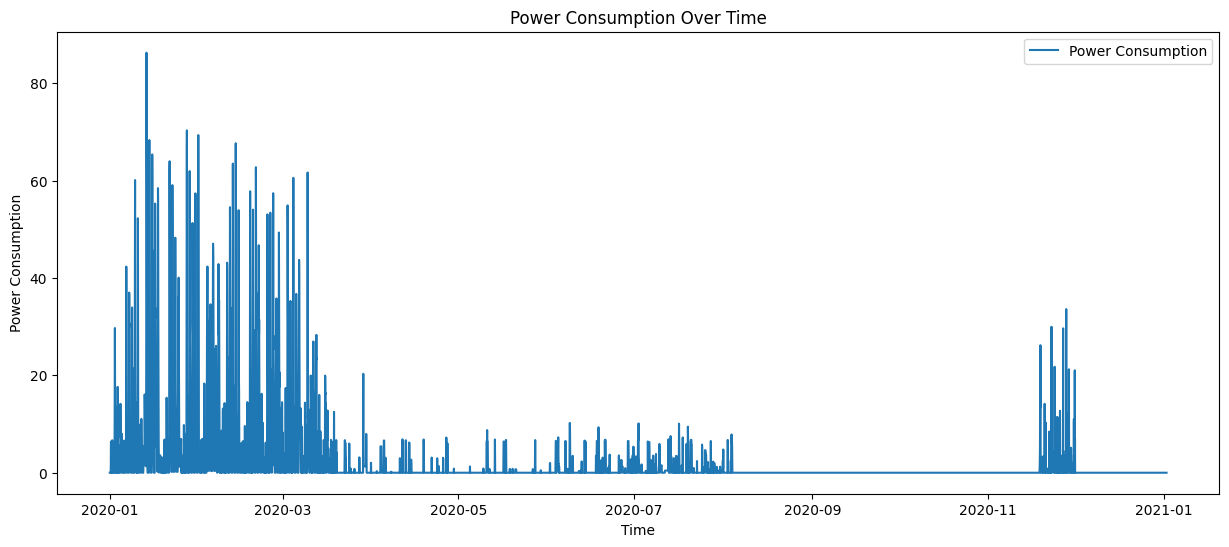

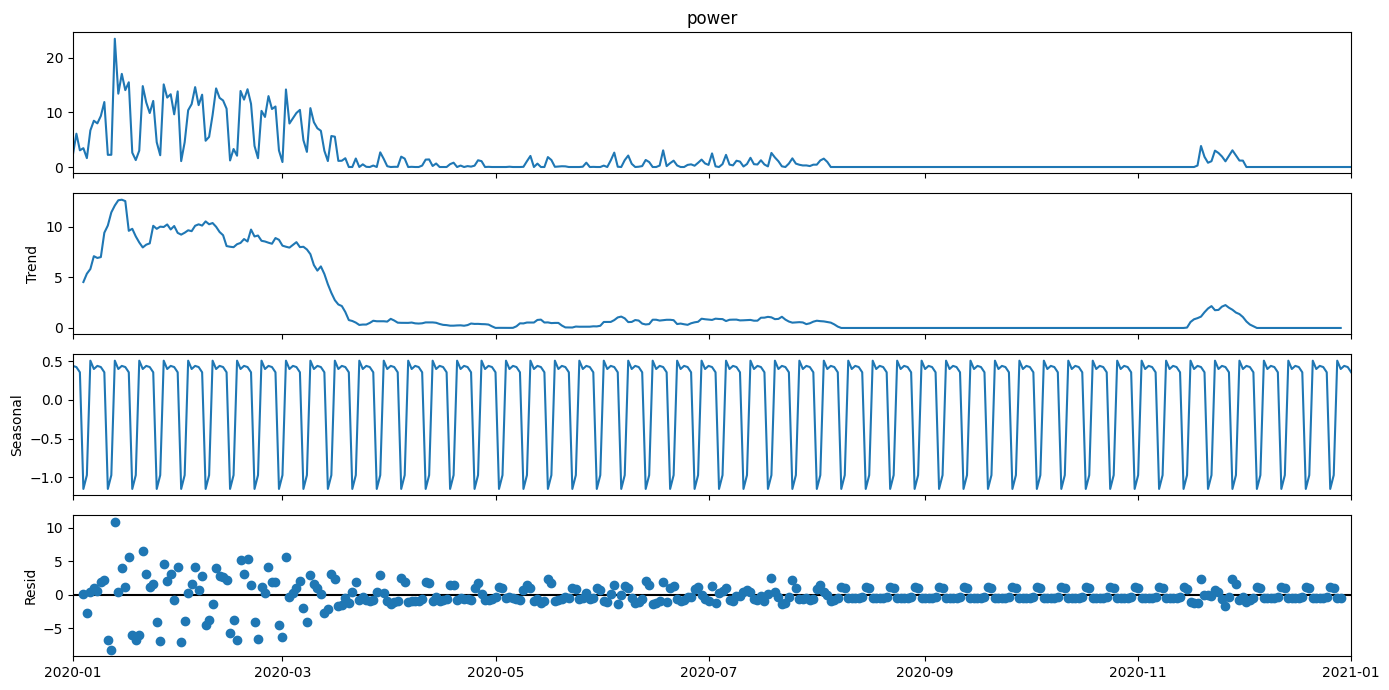

<Figure size 1400x700 with 0 Axes>

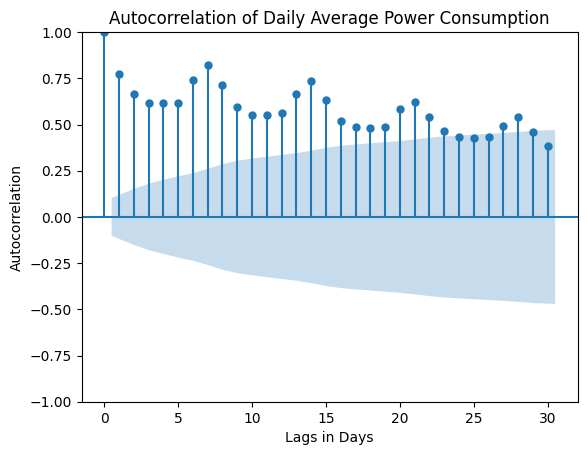

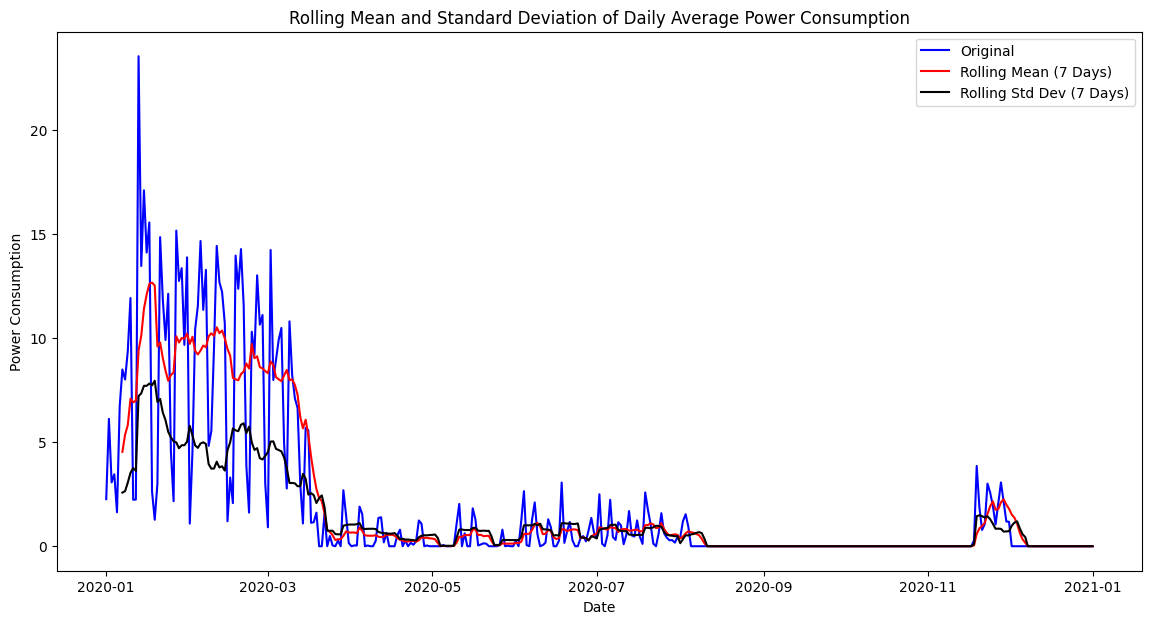

<ipython-input-4-e4e9bf714276>:56: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = result_df_copy.corr()  # Adjust as necessary


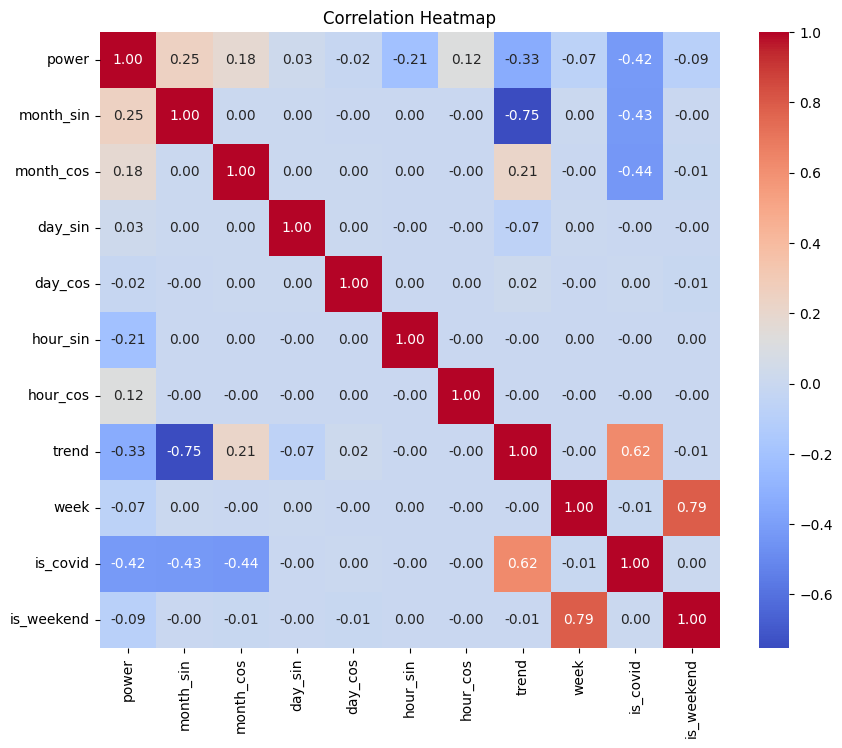

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

# Assuming 'result_df' is your DataFrame with 'time' and 'power' columns
# Convert 'time' to datetime if it's not already
result_df['time'] = pd.to_datetime(result_df['time'])

# Create a copy of result_df
result_df_copy = result_df.copy()

# Plotting Time Series of Power Consumption
plt.figure(figsize=(15, 6))
plt.plot(result_df_copy['time'], result_df_copy['power'], label='Power Consumption')
plt.title('Power Consumption Over Time')
plt.xlabel('Time')
plt.ylabel('Power Consumption')
plt.legend()
plt.show()

# Decomposing the time series (assuming hourly data, resampled to daily)
daily_power = result_df_copy.set_index('time')['power'].resample('D').mean().dropna()
decomposition = seasonal_decompose(daily_power, model='additive', period=7)
fig = decomposition.plot()
fig.set_size_inches(14, 7)
plt.tight_layout()
plt.show()

# Autocorrelation Plot
plt.figure(figsize=(14, 7))
plot_acf(daily_power, lags=30)
plt.title('Autocorrelation of Daily Average Power Consumption')
plt.xlabel('Lags in Days')
plt.ylabel('Autocorrelation')
plt.show()

# Rolling Mean and Standard Deviation
rolling_mean = daily_power.rolling(window=7).mean()
rolling_std = daily_power.rolling(window=7).std()
plt.figure(figsize=(14, 7))
plt.plot(daily_power, color='blue', label='Original')
plt.plot(rolling_mean, color='red', label='Rolling Mean (7 Days)')
plt.plot(rolling_std, color='black', label='Rolling Std Dev (7 Days)')
plt.title('Rolling Mean and Standard Deviation of Daily Average Power Consumption')
plt.xlabel('Date')
plt.ylabel('Power Consumption')
plt.legend()
plt.show()

# Assuming result_df includes transformed time features for detailed analysis
# Correlation Matrix and Heatmap
# (Ensure your DataFrame, result_df, includes all relevant columns for this part)
correlation_matrix = result_df_copy.corr()  # Adjust as necessary
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()


Backfilling Missing Values

In [ ]:
import pandas as pd

# Assuming 'result_df' is your DataFrame
# Assuming 'power' column represents power values

# Apply backward filling for 'power' column where the value is 0
result_df['power'] = result_df['power'].mask(result_df['power'] == 0).fillna(method='bfill')

print(result_df)


                    time     power  month_sin  month_cos   day_sin  day_cos  \
0    2020-01-01 00:00:00  1.896506        0.5   0.866025  0.201299  0.97953   
1    2020-01-01 01:00:00  1.896506        0.5   0.866025  0.201299  0.97953   
2    2020-01-01 02:00:00  1.896506        0.5   0.866025  0.201299  0.97953   
3    2020-01-01 03:00:00  1.896506        0.5   0.866025  0.201299  0.97953   
4    2020-01-01 04:00:00  1.896506        0.5   0.866025  0.201299  0.97953   
...                  ...       ...        ...        ...       ...      ...   
8803 2021-01-01 19:00:00       NaN        0.5   0.866025  0.201299  0.97953   
8804 2021-01-01 20:00:00       NaN        0.5   0.866025  0.201299  0.97953   
8805 2021-01-01 21:00:00       NaN        0.5   0.866025  0.201299  0.97953   
8806 2021-01-01 22:00:00       NaN        0.5   0.866025  0.201299  0.97953   
8807 2021-01-01 23:00:00       NaN        0.5   0.866025  0.201299  0.97953   

      hour_sin  hour_cos  trend  week  is_covid  is

In [ ]:
import pandas as pd

# Assuming 'time' column is in datetime format in result_df
# Filter for December 1st, 2020, 12pm (exclusive) to December 31st, 2020, 12pm (inclusive)
final_df = result_df[(result_df['time'] >= '2020-12-01 12:00:00') &
                        (result_df['time'] < '2021-01-01 12:00:00')]


print(final_df)


                    time  power     month_sin  month_cos   day_sin  day_cos  \
8052 2020-12-01 12:00:00    NaN -2.449294e-16   1.000000  0.201299  0.97953   
8053 2020-12-01 13:00:00    NaN -2.449294e-16   1.000000  0.201299  0.97953   
8054 2020-12-01 14:00:00    NaN -2.449294e-16   1.000000  0.201299  0.97953   
8055 2020-12-01 15:00:00    NaN -2.449294e-16   1.000000  0.201299  0.97953   
8056 2020-12-01 16:00:00    NaN -2.449294e-16   1.000000  0.201299  0.97953   
...                  ...    ...           ...        ...       ...      ...   
8791 2021-01-01 07:00:00    NaN  5.000000e-01   0.866025  0.201299  0.97953   
8792 2021-01-01 08:00:00    NaN  5.000000e-01   0.866025  0.201299  0.97953   
8793 2021-01-01 09:00:00    NaN  5.000000e-01   0.866025  0.201299  0.97953   
8794 2021-01-01 10:00:00    NaN  5.000000e-01   0.866025  0.201299  0.97953   
8795 2021-01-01 11:00:00    NaN  5.000000e-01   0.866025  0.201299  0.97953   

          hour_sin  hour_cos  trend  week  is_covid

In [ ]:
print(result_df)

                    time     power  month_sin  month_cos   day_sin  day_cos  \
0    2020-01-01 00:00:00  1.896506        0.5   0.866025  0.201299  0.97953   
1    2020-01-01 01:00:00  1.896506        0.5   0.866025  0.201299  0.97953   
2    2020-01-01 02:00:00  1.896506        0.5   0.866025  0.201299  0.97953   
3    2020-01-01 03:00:00  1.896506        0.5   0.866025  0.201299  0.97953   
4    2020-01-01 04:00:00  1.896506        0.5   0.866025  0.201299  0.97953   
...                  ...       ...        ...        ...       ...      ...   
8803 2021-01-01 19:00:00       NaN        0.5   0.866025  0.201299  0.97953   
8804 2021-01-01 20:00:00       NaN        0.5   0.866025  0.201299  0.97953   
8805 2021-01-01 21:00:00       NaN        0.5   0.866025  0.201299  0.97953   
8806 2021-01-01 22:00:00       NaN        0.5   0.866025  0.201299  0.97953   
8807 2021-01-01 23:00:00       NaN        0.5   0.866025  0.201299  0.97953   

      hour_sin  hour_cos  trend  week  is_covid  is

Drop Remaining Missing Values

In [ ]:
result_df = result_df.dropna(subset=['power'])
print(result_df)

                    time      power     month_sin  month_cos   day_sin  \
0    2020-01-01 00:00:00   1.896506  5.000000e-01   0.866025  0.201299   
1    2020-01-01 01:00:00   1.896506  5.000000e-01   0.866025  0.201299   
2    2020-01-01 02:00:00   1.896506  5.000000e-01   0.866025  0.201299   
3    2020-01-01 03:00:00   1.896506  5.000000e-01   0.866025  0.201299   
4    2020-01-01 04:00:00   1.896506  5.000000e-01   0.866025  0.201299   
...                  ...        ...           ...        ...       ...   
8040 2020-12-01 00:00:00  21.032000 -2.449294e-16   1.000000  0.201299   
8041 2020-12-01 01:00:00  21.032000 -2.449294e-16   1.000000  0.201299   
8042 2020-12-01 02:00:00  21.032000 -2.449294e-16   1.000000  0.201299   
8043 2020-12-01 03:00:00   7.104000 -2.449294e-16   1.000000  0.201299   
8044 2020-12-01 04:00:00   7.104000 -2.449294e-16   1.000000  0.201299   

      day_cos  hour_sin  hour_cos  trend  week  is_covid  is_weekend  
0     0.97953  0.000000  1.000000      1

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error

# Load the data
data = result_df.copy(deep=True)

# Shuffle the data
data = data.sample(frac=1, random_state=42)  # Shuffle with random seed for reproducibility

# Convert 'datetime' column to datetime format
data['datetime'] = pd.to_datetime(data['time'])

# Extract features
data['month'] = data['datetime'].dt.month
data['day'] = data['datetime'].dt.day
data['hour'] = data['datetime'].dt.hour

# Convert 'datetime' column to datetime format
final_df['datetime'] = pd.to_datetime(final_df['time'])

# Extract features
final_df['month'] = final_df['datetime'].dt.month
final_df['day'] = final_df['datetime'].dt.day
final_df['hour'] = final_df['datetime'].dt.hour

# Select features and target variable
features = ['month', 'day', 'hour']
target = 'power'

# Split data into train and test sets
train_data = data

# Define preprocessing steps for numerical features
numeric_features = ['month', 'day', 'hour']
numeric_transformer = StandardScaler()

# Combine preprocessing steps for all features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ])

# Initialize GBM model within a pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor())  # GBM model
])

# Adjusting hyperparameters for better performance
param_grid = {
    'regressor__n_estimators': [100, 200, 300],  # Increase the number of boosting stages
    'regressor__learning_rate': [0.01, 0.05, 0.1],  # Adjust the step size shrinkage
    'regressor__max_depth': [5, 8, 10]  # Adjust the maximum depth of the individual regression estimators
}

# Perform Grid Search Cross Validation to find the best hyperparameters
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(train_data[features], train_data[target])

# Get the best model from grid search
best_model = grid_search.best_estimator_

# # Make predictions on the test set
# predictions = best_model.predict(test_data[features])

# # Calculate Mean Absolute Error (MAE) on the test set
# mae = mean_absolute_error(test_data[target], predictions)
# print("Mean Absolute Error (MAE) on the test set:", mae)

# Predict kWh consumed for each hour of December

# Make predictions for December hours
december_predictions = best_model.predict(final_df[features])

# Create DataFrame for December predictions
december_predictions_df = pd.DataFrame({'Row ID': range(1, len(december_predictions) + 1), 'Predicted': december_predictions})

# Save predictions to CSV file
december_predictions_df.to_csv('GradientBoostingRegressor_backfill.csv', index=False)

print("GradientBoostingRegressor predictions saved to 'GradientBoostingRegressor_backfill.csv'.")


GradientBoostingRegressor predictions saved to 'GradientBoostingRegressor_backfill.csv'.


Gradient Boost Regresspr

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error

# Load the data
data = result_df.copy(deep=True)


# Select features and target variable
features = ['trend', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'week']
target = 'power'

# Choose one particular month (except December) for testing
test_month = 1  # For example, October

for test_month in range(8):
  if data[data['time'].dt.month == test_month].empty:
      print("No data available for the specified testing month.")
  else:
      # Split data into train and test sets
      train_data = data[data['time'].dt.month != test_month]
      test_data = data[data['time'].dt.month == test_month]

      # Define preprocessing steps for numerical features
      numeric_features = features
      numeric_transformer = StandardScaler()

      # Combine preprocessing steps for all features
      preprocessor = ColumnTransformer(
          transformers=[
              ('num', numeric_transformer, numeric_features)
          ])

      # Initialize GBM model within a pipeline
      model = Pipeline(steps=[
          ('preprocessor', preprocessor),
          ('regressor', GradientBoostingRegressor())  # GBM model
      ])

      # Adjusting hyperparameters for better performance
      param_grid = {
          'regressor__n_estimators': [100, 200, 300],  # Increase the number of boosting stages
          'regressor__learning_rate': [0.01, 0.05, 0.1],  # Adjust the step size shrinkage
          'regressor__max_depth': [5, 8, 10],  # Adjust the maximum depth of the individual regression estimators
          # 'regressor__min_samples_split': [2, 5, 10],  # Adding min_samples_split for more control over tree growth
          # 'regressor__subsample': [0.8, 0.9, 1.0]  # Adding subsample for stochastic gradient boosting

      }

      # Perform Grid Search Cross Validation to find the best hyperparameters
      grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
      grid_search.fit(train_data[features], train_data[target])

      # Get the best model from grid search
      best_model = grid_search.best_estimator_

      print("Best score (negative MAE) from CV:", grid_search.best_score_)


      # Make predictions on the test set if it's not empty
      predictions = best_model.predict(test_data[features])

      # Calculate Mean Absolute Error (MAE) on the test set
      mae = mean_absolute_error(test_data[target], predictions)
      print("Mean Absolute Error (MAE) on the test set month:",test_month, mae)


No data available for the specified testing month.
Best score (negative MAE) from CV: -2.242920263991059
Mean Absolute Error (MAE) on the test set month: 1 5.68706989194356
Best score (negative MAE) from CV: -2.228221052674824
Mean Absolute Error (MAE) on the test set month: 2 5.222392692552373


KeyboardInterrupt: 

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error

# Load the data
data = result_df.copy(deep=True)


# Select features and target variable
features = ['trend', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'week']
target = 'power'

# Iterate through months for training and testing
for test_month in range(1, 13):  # Adjusted range to iterate through all months
    if data[data['month'] == test_month].empty:
        print("No data available for the specified testing month:", test_month)
    else:
        # Split data into train and test sets
        train_data = data[data['month'] != test_month]
        test_data = data[data['month'] == test_month]

        # Define preprocessing steps for numerical features
        numeric_features = ['month', 'day', 'hour']
        numeric_transformer = StandardScaler()

        # Combine preprocessing steps
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numeric_features),
            ])

        # Initialize the XGB model within a pipeline
        model = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', XGBRegressor(objective='reg:squarederror'))  # XGB model
        ])

        # Define hyperparameters for XGB
        param_grid = {
            'regressor__n_estimators': [100, 200, 300],
            'regressor__learning_rate': [0.01, 0.05, 0.1],
            'regressor__max_depth': [3, 5, 7]
        }

        # Perform Grid Search
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
        grid_search.fit(train_data[features], train_data[target])

        # Best model from grid search
        best_model = grid_search.best_estimator_

        # Predictions on the test set
        predictions = best_model.predict(test_data[features])

        # MAE on the test set
        mae = mean_absolute_error(test_data[target], predictions)
        print(f"Mean Absolute Error (MAE) for month {test_month}:", mae)


Mean Absolute Error (MAE) for month 1: 8.22987109043192
Mean Absolute Error (MAE) for month 2: 6.697517426598397
Mean Absolute Error (MAE) for month 3: 6.610904962242425
Mean Absolute Error (MAE) for month 4: 4.213034816230719
Mean Absolute Error (MAE) for month 5: 1.4336572936386023
Mean Absolute Error (MAE) for month 6: 2.102467661055517
Mean Absolute Error (MAE) for month 7: 1.8182895665907253
Mean Absolute Error (MAE) for month 8: 1.4338076209931907
Mean Absolute Error (MAE) for month 9: 0.5898311903124617
Mean Absolute Error (MAE) for month 10: 0.4241123416028973
Mean Absolute Error (MAE) for month 11: 1.5874691574834752
Mean Absolute Error (MAE) for month 12: 14.685209210681915


In [ ]:
import pandas as pd
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet

import warnings

import logging

# Disable debug and info messages
logging.getLogger('prophet').setLevel(logging.WARNING)
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)


# Ignore all warnings
warnings.filterwarnings("ignore")

# Your code here

# Restore default warning behavior


# from fbprophet import Prophet

# Load the data
data = result_df.copy(deep=True)


# Select features and target variable
features = ['trend', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'week']
target = 'power'

# Choose one particular month (except December) for testing
for test_month in range(8):
    if data[data['time'].dt.month == test_month].empty:
        print("No data available for the specified testing month.")
    else:
        # Split data into train and test sets
        train_data = data[data['time'].dt.month != test_month]
        test_data = data[data['time'].dt.month == test_month]


        # ARIMA model
        arima_model = ARIMA(train_data[target], order=(5, 1, 0))
        arima_fit = arima_model.fit()
        arima_predictions = arima_fit.forecast(steps=len(test_data))

        # SARIMA model (Seasonal ARIMA)
        sarima_model = SARIMAX(train_data[target], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
        sarima_fit = sarima_model.fit(disp=0)
        sarima_predictions = sarima_fit.forecast(steps=len(test_data))

        # Prophet model
        prophet_model = Prophet()
        prophet_data = train_data[['time', 'power']].copy()
        prophet_data.columns = ['ds', 'y']
        prophet_model.fit(prophet_data)
        future = prophet_model.make_future_dataframe(periods=len(test_data), freq='H', include_history=False)
        prophet_predictions = prophet_model.predict(future)['yhat']

        # Calculate Mean Absolute Error (MAE) for each model
        arima_mae = mean_absolute_error(test_data[target], arima_predictions)
        sarima_mae = mean_absolute_error(test_data[target], sarima_predictions)
        prophet_mae = mean_absolute_error(test_data[target], prophet_predictions)

        print("Test Month: ", test_month)
        print("Mean Absolute Error (MAE) for ARIMA:", arima_mae)
        print("Mean Absolute Error (MAE) for SARIMA:", sarima_mae)
        print("Mean Absolute Error (MAE) for Prophet:", prophet_mae)
        print('\n')


No data available for the specified testing month.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1yzyoidq/uotmhadg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1yzyoidq/_gqxdm3y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62179', 'data', 'file=/tmp/tmp1yzyoidq/uotmhadg.json', 'init=/tmp/tmp1yzyoidq/_gqxdm3y.json', 'output', 'file=/tmp/tmp1yzyoidq/prophet_modelxq8kbfo2/prophet_model-20240401031250.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:12:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:12:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Test Month:  1
Mean Absolute Error (MAE) for ARIMA: 9.930545838373325
Mean Absolute Error (MAE) for SARIMA: 12.676939739496406
Mean Absolute Error (MAE) for Prophet: 8.368302081360532




DEBUG:cmdstanpy:input tempfile: /tmp/tmp1yzyoidq/1ntwkokz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1yzyoidq/8ah10hcn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15183', 'data', 'file=/tmp/tmp1yzyoidq/1ntwkokz.json', 'init=/tmp/tmp1yzyoidq/8ah10hcn.json', 'output', 'file=/tmp/tmp1yzyoidq/prophet_model_3akhr4g/prophet_model-20240401031307.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:13:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:13:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Test Month:  2
Mean Absolute Error (MAE) for ARIMA: 10.31493000955625
Mean Absolute Error (MAE) for SARIMA: 12.474331903304506
Mean Absolute Error (MAE) for Prophet: 8.626121408910473




DEBUG:cmdstanpy:input tempfile: /tmp/tmp1yzyoidq/h22g3_rc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1yzyoidq/bbms24c9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4332', 'data', 'file=/tmp/tmp1yzyoidq/h22g3_rc.json', 'init=/tmp/tmp1yzyoidq/bbms24c9.json', 'output', 'file=/tmp/tmp1yzyoidq/prophet_modeltt8rzxkh/prophet_model-20240401031326.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:13:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:13:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Test Month:  3
Mean Absolute Error (MAE) for ARIMA: 8.31122411165629
Mean Absolute Error (MAE) for SARIMA: 12.72802528704386
Mean Absolute Error (MAE) for Prophet: 4.873958240514634




DEBUG:cmdstanpy:input tempfile: /tmp/tmp1yzyoidq/rnojsibs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1yzyoidq/wz1uneo_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27337', 'data', 'file=/tmp/tmp1yzyoidq/rnojsibs.json', 'init=/tmp/tmp1yzyoidq/wz1uneo_.json', 'output', 'file=/tmp/tmp1yzyoidq/prophet_modellkfsztcs/prophet_model-20240401031352.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:13:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:13:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Test Month:  4
Mean Absolute Error (MAE) for ARIMA: 8.375755562521663
Mean Absolute Error (MAE) for SARIMA: 12.41467792358095
Mean Absolute Error (MAE) for Prophet: 3.01725955416562




DEBUG:cmdstanpy:input tempfile: /tmp/tmp1yzyoidq/wu7zk489.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1yzyoidq/dti32hjl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34364', 'data', 'file=/tmp/tmp1yzyoidq/wu7zk489.json', 'init=/tmp/tmp1yzyoidq/dti32hjl.json', 'output', 'file=/tmp/tmp1yzyoidq/prophet_modelfir8m6ka/prophet_model-20240401031408.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:14:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:14:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Test Month:  5
Mean Absolute Error (MAE) for ARIMA: 8.986016644962124
Mean Absolute Error (MAE) for SARIMA: 13.203961767281335
Mean Absolute Error (MAE) for Prophet: 3.098921359080536




DEBUG:cmdstanpy:input tempfile: /tmp/tmp1yzyoidq/7k9mpday.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1yzyoidq/2a_amdng.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81948', 'data', 'file=/tmp/tmp1yzyoidq/7k9mpday.json', 'init=/tmp/tmp1yzyoidq/2a_amdng.json', 'output', 'file=/tmp/tmp1yzyoidq/prophet_modelsqmshqos/prophet_model-20240401031426.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:14:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:14:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Test Month:  6
Mean Absolute Error (MAE) for ARIMA: 8.740892034235387
Mean Absolute Error (MAE) for SARIMA: 12.732392392453818
Mean Absolute Error (MAE) for Prophet: 2.6484649685609947




DEBUG:cmdstanpy:input tempfile: /tmp/tmp1yzyoidq/cmjxh_ct.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1yzyoidq/vndayppy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78448', 'data', 'file=/tmp/tmp1yzyoidq/cmjxh_ct.json', 'init=/tmp/tmp1yzyoidq/vndayppy.json', 'output', 'file=/tmp/tmp1yzyoidq/prophet_model8kwqe34a/prophet_model-20240401031443.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:14:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:14:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Test Month:  7
Mean Absolute Error (MAE) for ARIMA: 8.892676909224596
Mean Absolute Error (MAE) for SARIMA: 13.179368840370547
Mean Absolute Error (MAE) for Prophet: 2.894469208504089




In [ ]:
import pandas as pd
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet

import warnings

import logging

# Disable debug and info messages
logging.getLogger('prophet').setLevel(logging.WARNING)
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)


# Ignore all warnings
warnings.filterwarnings("ignore")

# Your code here

# Restore default warning behavior


# from fbprophet import Prophet

# Load the data
data = result_df.copy(deep=True)

# Shuffle the data
# data = data.sample(frac=1, random_state=42)  # Shuffle with random seed for reproducibility

# Convert 'datetime' column to datetime format
data['datetime'] = pd.to_datetime(data['time'])

# Extract features
data['month'] = data['datetime'].dt.month
data['day'] = data['datetime'].dt.day
data['hour'] = data['datetime'].dt.hour

# Select features and target variable
features = ['month', 'day', 'hour']
target = 'power'

# Choose one particular month (except December) for testing
for test_month in range(8):
    if data[data['month'] == test_month].empty:
        print("No data available for the specified testing month.")
    else:
        # Split data into train and test sets
        train_data = data[data['month'] != test_month]
        test_data = data[data['month'] == test_month]


        # ARIMA model
        arima_model = ARIMA(train_data[target], order=(5, 1, 0))
        arima_fit = arima_model.fit()
        arima_predictions = arima_fit.forecast(steps=len(test_data))

        # SARIMA model (Seasonal ARIMA)
        sarima_model = SARIMAX(train_data[target], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
        sarima_fit = sarima_model.fit(disp=0)
        sarima_predictions = sarima_fit.forecast(steps=len(test_data))

        # Prophet model
        prophet_model = Prophet()
        prophet_data = train_data[['datetime', 'power']].copy()
        prophet_data.columns = ['ds', 'y']
        prophet_model.fit(prophet_data)
        future = prophet_model.make_future_dataframe(periods=len(test_data), freq='H', include_history=False)
        prophet_predictions = prophet_model.predict(future)['yhat']

        # Calculate Mean Absolute Error (MAE) for each model
        arima_mae = mean_absolute_error(test_data[target], arima_predictions)
        sarima_mae = mean_absolute_error(test_data[target], sarima_predictions)
        prophet_mae = mean_absolute_error(test_data[target], prophet_predictions)

        print("Test Month: ", test_month)
        print("Mean Absolute Error (MAE) for ARIMA:", arima_mae)
        print("Mean Absolute Error (MAE) for SARIMA:", sarima_mae)
        print("Mean Absolute Error (MAE) for Prophet:", prophet_mae)
        print('\n')


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import warnings

# Ignore all warnings for cleaner output
warnings.filterwarnings("ignore")

# Assuming 'result_df' and 'december_df' are already loaded with the necessary data

# Preprocess the data
# Load the data
data = result_df.copy(deep=True)


# Select features and target variable
features = ['trend', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'week']
target = 'power'

# Initialize the scaler
scaler = StandardScaler()


# Apply feature scaling
# data[features] = scaler.fit_transform(data[features])

# Function to prepare LSTM data
def prepare_data_for_lstm(data, features, target, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        seq_x = data[features].iloc[i:(i + n_steps)].values
        seq_y = data[target].iloc[i + n_steps]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_steps = 3  # Number of time steps for sequences

# Months to iterate over, currently set to December only
months = [12]

print(data)

for test_month in range(8):
    # Check if data for the month exists
    if data[data['time'].dt.month == test_month].empty:
        print(f"No data available for month {test_month}.")
        continue

    # Split data based on month
    train_data = data[data['time'].dt.month != test_month]
    test_data = data[data['time'].dt.month == test_month]

    # Prepare the data for LSTM
    X_train, y_train = prepare_data_for_lstm(train_data, features, target, n_steps)
    X_test, y_test = prepare_data_for_lstm(test_data, features, target, n_steps)

    # Reshape data for LSTM model
    X_train = X_train.reshape((X_train.shape[0], n_steps, len(features)))
    X_test = X_test.reshape((X_test.shape[0], n_steps, len(features)))

    # Define and compile the LSTM model
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(n_steps, len(features))))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Train the model
    model.fit(X_train, y_train, epochs=200, verbose=0)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate and print the Mean Absolute Error
    lstm_mae = mean_absolute_error(y_test, y_pred)
    print(f"Mean Absolute Error (MAE) for month {test_month}: {lstm_mae}")

    # (Optional) Save predicted values to CSV
    predicted_df = pd.DataFrame({'Predicted': y_pred.flatten()}, index=test_data.index[n_steps:])
    predicted_df.index.name = 'Row Id'
    predicted_df.to_csv(f'predicted_values_month_{test_month}.csv')


                    time      power     month_sin  month_cos   day_sin  \
0    2020-01-01 00:00:00   1.896506  5.000000e-01   0.866025  0.201299   
1    2020-01-01 01:00:00   1.896506  5.000000e-01   0.866025  0.201299   
2    2020-01-01 02:00:00   1.896506  5.000000e-01   0.866025  0.201299   
3    2020-01-01 03:00:00   1.896506  5.000000e-01   0.866025  0.201299   
4    2020-01-01 04:00:00   1.896506  5.000000e-01   0.866025  0.201299   
...                  ...        ...           ...        ...       ...   
8040 2020-12-01 00:00:00  21.032000 -2.449294e-16   1.000000  0.201299   
8041 2020-12-01 01:00:00  21.032000 -2.449294e-16   1.000000  0.201299   
8042 2020-12-01 02:00:00  21.032000 -2.449294e-16   1.000000  0.201299   
8043 2020-12-01 03:00:00   7.104000 -2.449294e-16   1.000000  0.201299   
8044 2020-12-01 04:00:00   7.104000 -2.449294e-16   1.000000  0.201299   

      day_cos  hour_sin  hour_cos  trend  week  is_covid  is_weekend  
0     0.97953  0.000000  1.000000      1

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Load the data
data = result_df.copy(deep=True)

data = data.sample(frac=1, random_state=42)  # Shuffle with random seed for reproducibility


# Convert 'datetime' column to datetime format
data['datetime'] = pd.to_datetime(data['time'])

# Extract features
data['month'] = data['datetime'].dt.month
data['day'] = data['datetime'].dt.day
data['hour'] = data['datetime'].dt.hour

# Select features and target variable
features = ['month', 'day', 'hour']
target = 'power'

# Split data into train and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Initialize and train the model
model = RandomForestRegressor(random_state=42)

# Define hyperparameters to tune
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Perform Grid Search Cross Validation to find the best hyperparameters
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(train_data[features], train_data[target])

# Get the best model from grid search
best_model = grid_search.best_estimator_

# Make predictions on the test set
predictions = best_model.predict(test_data[features])

# Calculate Mean Absolute Error (MAE) on the test set
mae = mean_absolute_error(test_data[target], predictions)
print("Mean Absolute Error (MAE) on the test set:", mae)


Mean Absolute Error (MAE) on the test set: 3.939309477499694
